# Denoising 2D Generated Datasets

In [ ]:
using Plots
using Flux
using BSON
using JSON
using StatsBase
using Printf

In [ ]:
using Revise
using DenoisingDiffusion 
using DenoisingDiffusion: train!

┌ Info: Precompiling DenoisingDiffusion [32e9e46b-ad0f-4c80-b32d-4f6f824844ef]
└ @ Base loading.jl:1423


In [ ]:
include("datasets.jl");
includet("utilities.jl");

## Data

In [ ]:
n_samples = 1000
X = normalize_neg_one_to_one(make_spiral(n_samples))

2×1000 Matrix{Float64}:
 -0.861431  0.446152  -0.874327   0.300942  …   0.618668  -0.813366  0.159157
 -0.348773  0.793894  -0.154911  -0.315047     -0.708983  -0.504316  0.943032

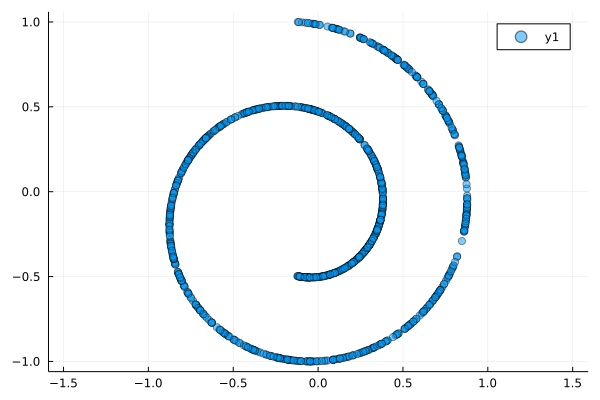

In [ ]:
scatter(X[1, :], X[2, :], 
    alpha=0.5,
    aspectratio=:equal,
    )

### Diffusion

In [ ]:
num_timesteps = 40
βs = linear_beta_schedule(num_timesteps, 8e-6, 9e-5)
#βs = cosine_beta_schedule(num_timesteps, 0)
diffusion = GaussianDiffusion(Vector{Float32}, βs, (2,), identity)

GaussianDiffusion{Vector{Float32}}(num_timesteps=40, data_shape=(2,), denoise_fn=identity, buffers_size=2.344 KiB)

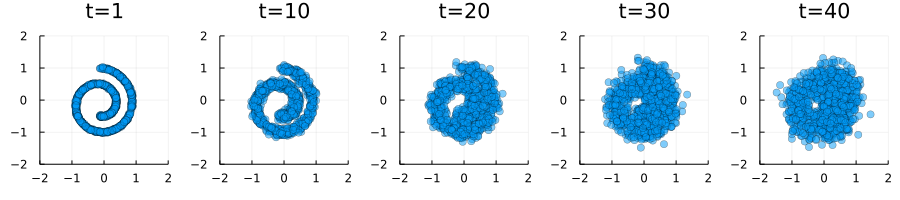

In [ ]:
canvases = []
for frac in [0.0, 0.25, 0.5, 0.75, 1]
    local p
    timestep = max(1, ceil(Int, frac * num_timesteps))
    Xt = q_sample(diffusion, X, timestep)
    p = scatter(Xt[1, :], Xt[2, :], alpha=0.5, label="", 
        aspectratio=:equal,
        xlims = (-2, 2), ylims=(-2, 2),
        title="t=$timestep"
        )
    push!(canvases, p)
end

p = plot(canvases..., layout=(1, 5), link=:both, size=(900, 200))
#savefig("../outputs/spiral_forward.png")
p

In [ ]:
XT = q_sample(diffusion, X, num_timesteps)
anim = @animate for t ∈ 1:(num_timesteps + 10)
    if t < num_timesteps
        Xt = q_sample(diffusion, X, t)
    else
        Xt = XT
        t = num_timesteps
    end
    p = scatter(Xt[1, :], Xt[2, :], alpha=0.5, label="", 
        aspectratio=:equal,
        xlims = (-2, 2), ylims=(-2, 2),
        title="t=$t"
    )
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_QIgV26", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion\outputs\spiral_forward.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion\\outputs\\spiral_forward.gif")
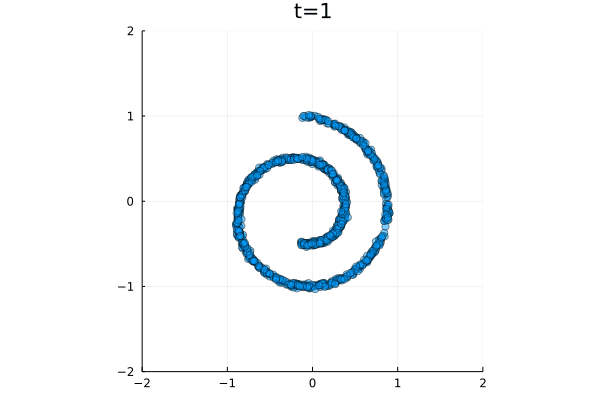

In [ ]:
gif(anim, "../outputs/spiral_forward.gif", fps=8)

In [ ]:
reverse_anim = @animate for t ∈ (num_timesteps):-1:-10
    if t < 1
        t = 1
        Xt = X
    else
        Xt = q_sample(diffusion, X, t)
    end
    p = scatter(Xt[1, :], Xt[2, :], alpha=0.5, label="", 
        aspectratio=:equal,
        xlims = (-2, 2), ylims=(-2, 2),
        title="t=$t"
    )
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_9roKow", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png", "000051.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion\outputs\spiral_forward_reversed.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion\\outputs\\spiral_forward_reversed.gif")
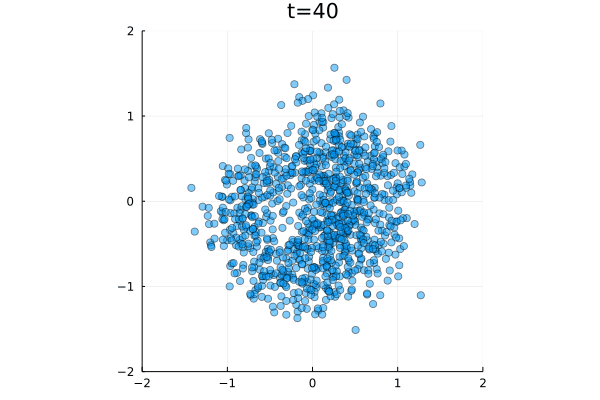

In [ ]:
gif(reverse_anim, "../outputs/spiral_forward_reversed.gif", fps=8)

## Test

### load model

In [ ]:
directory = "../outputs/20221101_1920";
diffusion_path = joinpath(directory, "diffusion.bson");
history_path = joinpath(directory, "history.json");

In [ ]:
BSON.@load diffusion_path diffusion
println("data shape:    $(diffusion.data_shape)")
num_timesteps = diffusion.num_timesteps
println("num timesteps: $(num_timesteps)")
diffusion.denoise_fn

data shape:    (2,)
num timesteps: 40


ConditionalChain(
  Parallel(
    Base.Broadcast.BroadcastFunction(+),
    Dense(2 => 16),                     # 48 parameters
    Chain(
      SinusoidalPositionEmbedding(40 => 16),
      Dense(16 => 16),                  # 272 parameters
    ),
  ),
  NNlib.swish,
  Parallel(
    Base.Broadcast.BroadcastFunction(+),
    Dense(16 => 16),                    # 272 parameters
    Chain(
      SinusoidalPositionEmbedding(40 => 16),
      Dense(16 => 16),                  # 272 parameters
    ),
  ),
  NNlib.swish,
  Parallel(
    Base.Broadcast.BroadcastFunction(+),
    Dense(16 => 16),                    # 272 parameters
    Chain(
      SinusoidalPositionEmbedding(40 => 16),
      Dense(16 => 16),                  # 272 parameters
    ),
  ),
  NNlib.swish,
  Dense(16 => 2),                       # 34 parameters
)         # Total: 14 trainable arrays, 1_442 parameters,
          # plus 3 non-trainable, 1_920 parameters, summarysize 14.570 KiB.

In [ ]:
history = Dict()
open(history_path, "r") do f
    global history
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 3 entries:
  "train_loss" => Any[1.00984, 0.971491, 0.959772, 0.972448, 0.954206, 0.962856…
  "epoch_size" => 10000
  "val_loss"   => Any[0.931513, 0.955245, 0.935489, 0.961786, 0.919854, 0.93877…

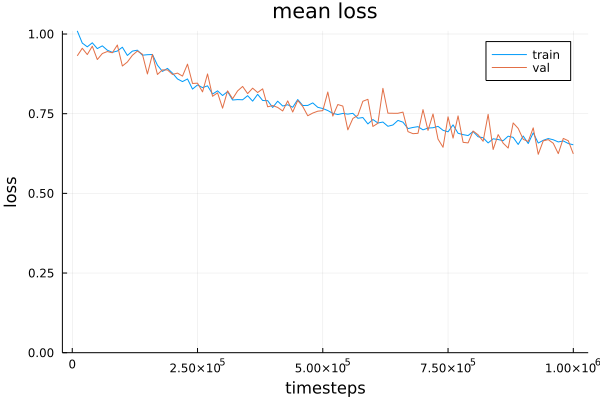

In [ ]:
timesteps = (1:length(history["train_loss"])) * history["epoch_size"]

p = plot(timesteps, history["train_loss"], 
    label="train", ylims=(0, Inf),
    title="mean loss",
    xlabel="timesteps",
    ylabel="loss",
)
plot!(p, timesteps, history["val_loss"], label="val")
savefig(p, joinpath(directory, "loss.png"))
p

### sample

In [ ]:
num_samples = 1000
X0s, X0_ests = p_sample_loop_all(diffusion, num_samples) ;
size(X0s)

Sampling... 100%|████████████████████████████████████████| Time: 0:00:03


(2, 1000, 40)

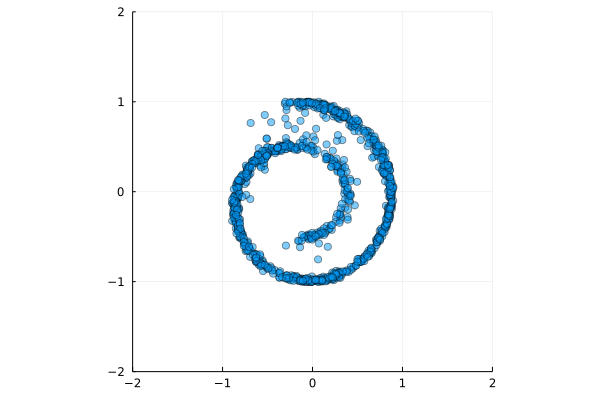

In [ ]:
scatter(X0s[1, :, end], X0s[2, :, end], alpha=0.5, label="", 
    aspectratio=:equal,    xlims = (-2, 2), ylims=(-2, 2),
    )

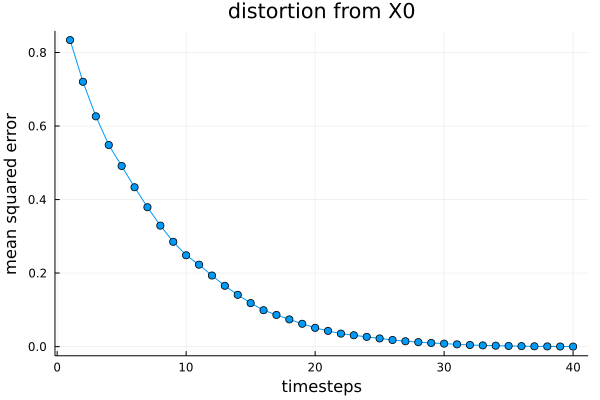

In [ ]:
D = size(X0s, 2)
distortion_est = sum((X0s .- X0_ests).^2, dims=(1, 2)) / D
distortion_est = reshape(distortion_est, :)

p = plot(1:num_timesteps, distortion_est, label="",
    xlabel="timesteps",
    ylabel="mean squared error",
    title="distortion from X0",
    markershape=:circle,
)

#savefig(p, joinpath(directory, "distortion.png"))
p

### Compare closest points to spiral

In [ ]:
## spiral
θmin = 1.5π
θmax = 4.5π
xmax = 4.5π
xmin = -3.5π
x_func(t) = t * cos(t) 
y_func(t) = t * sin(t)

## s curve
# θmin = -3π/2
# θmax = +3π/2
# xmax = 2
# xmin = -2
# x_func(t) = sin(t)
# y_func(t) = sign(t) * (cos(t) - 1.0)

## normalize
scale = 2/(xmax - xmin)
shift = -1 - scale * xmin

x_func_norm(t) = scale * x_func(t) + shift
y_func_norm(t) = scale * y_func(t) + shift

θ = (θmin:0.01:θmax)
x = x_func_norm.(θ);
y = y_func_norm.(θ);

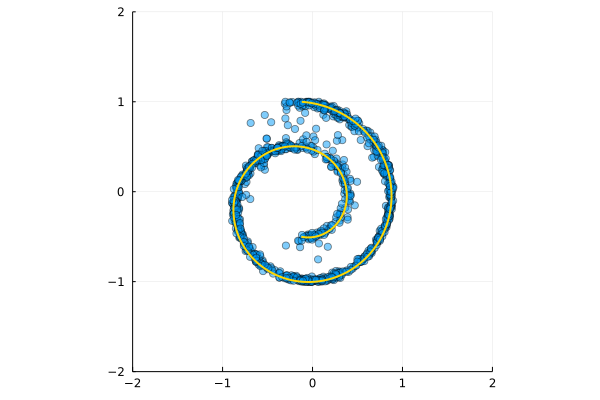

In [ ]:
points = X0s[:, :, end]
p = scatter(points[1, :], points[2, :], alpha=0.5, label="", aspectratio=:equal, xlims=(-2, 2), ylims=(-2, 2))
plot!(p, x, y, label="", linewidth=2, color=:gold)

In [ ]:
f(p, t)   = (x_func_norm(t) - p[1])^2 + (y_func_norm(t) - p[2])^2;
## spiral
df(p, t)  = t * scale + (shift - p[1]) * (cos(t) - t * sin(t)) + (shift - p[2]) * (sin(t) + t * cos(t));
ddf(p, t) = 1 * scale - (shift - p[1]) * (2sin(t) + t * cos(t)) + (shift - p[2]) * (2cos(t) - t * sin(t));
## s curve
# df(p, t)  = (scale + p[2] * sign(t)) * sin(t) - p[1] * cos(t) 
# ddf(p, t) = (scale + p[2] * sign(t)) * cos(t) + p[1] * sin(t)
## solver
solver(p) = argmin_func(t->f(p, t), t->df(p, t), t->ddf(p, t), θmin, θmax)

solver (generic function with 1 method)

In [ ]:
closest_points = Matrix(undef, num_samples, num_timesteps);
closest_distances = Matrix(undef, num_samples, num_timesteps);

@time for timestep in 1:num_timesteps
    points = X0s[:, :, timestep]
    ts = [solver(points[:, i]) for i in 1:num_samples]
    ds = [f(points[:, i], ts[i]) for i in 1:num_samples]
    
    closest_points[:, timestep] .= ts
    closest_distances[:, timestep] .= sqrt.(ds)
end

  3.299074 seconds (78.53 M allocations: 1.357 GiB, 9.98% gc time, 17.13% compilation time)


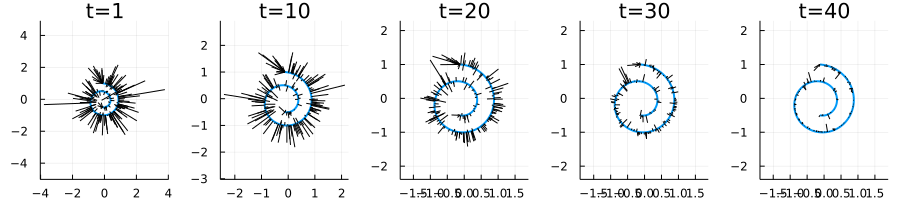

In [ ]:
canvases = []
n = 200
for frac in [0.0, 0.25, 0.5, 0.75, 1.0]
    local p
    timestep = max(1, ceil(Int, frac * num_timesteps))
    p = plot(x, y, aspectratio=:equal, label="", linewidth=2, title="t=$timestep")
    points = X0s[:, :, timestep]
    
    #scatter!(p, points[1, 1:n], points[2, 1:n], alpha=0.5, label="points", aspectratio=:equal)
    #scatter!(p, xt[1:n], yt[1:n], label="roots")
    
    ts = closest_points[:, timestep]
    xt = x_func_norm.(ts)
    yt = y_func_norm.(ts)
    for i in 1:n
        plot!(p, [points[1, i] ;xt[i]], [points[2, i]; yt[i]], label="", color=:black )
    end
    push!(canvases, p)
end
p = plot(canvases..., layout=(1, 5), link=:both, size=(900, 200))
savefig(p, joinpath(directory, "closest_points.png"))
p

Starting similarity: 0.4945
Final similarity:    0.0273


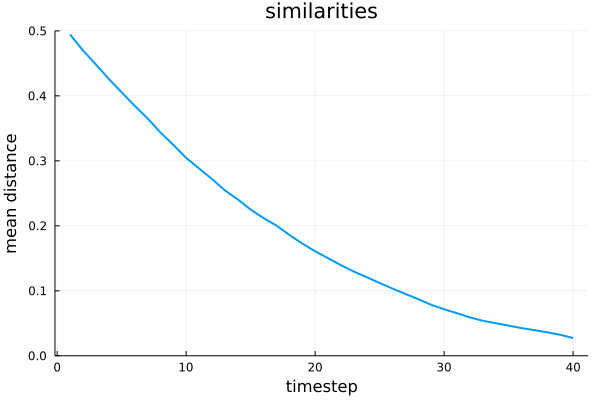

In [ ]:
similarities = mean(closest_distances, dims=1)
@printf("Starting similarity: %.4f\n", similarities[1])
@printf("Final similarity:    %.4f\n", similarities[end])

p = plot(1:num_timesteps, vec(similarities),
    ylims=(0, 0.5),
    label="",
    xlabel="timestep",
    ylabel="mean distance",
    title="similarities",
    linewidth=2
)

savefig(p, joinpath(directory, "similarties.png"))
p

### Animations 

In [ ]:
anim_denoise = @animate for i ∈ 1:(num_timesteps + 10)
    i = i > num_timesteps ? num_timesteps : i
    scatter(X0s[1, :, i], X0s[2, :, i], 
        alpha=0.5, 
        title="i=$i", 
        label="",
        aspectratio=:equal,
        xlims=(-2, 2), ylims=(-2, 2),
        figsize=(400, 400),
    )
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_3nswFT", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion\outputs\20221101_1920\reverse.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion\\outputs\\20221101_1920\\reverse.gif")
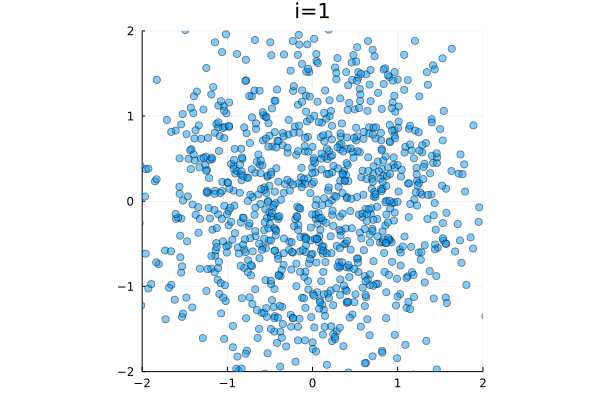

In [ ]:
gif(anim_denoise, joinpath(directory, "reverse.gif"), fps=8)

In [ ]:
anim_estimates = @animate for i ∈ 1:(num_timesteps + 10)
    i = i > num_timesteps ? num_timesteps : i
    scatter(X0_ests[1, :, i], X0_ests[2, :, i], 
        alpha=0.5, 
        title="i=$i", 
        label="",
        aspectratio=:equal,
        xlims = (-2, 2), ylims=(-2, 2),
        figsize=(400, 400),
    )
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_5kCsf2", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion\outputs\20221101_1920\estimates.gif
└ @ Plots C:\Users\sinai\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion\\outputs\\20221101_1920\\estimates.gif")
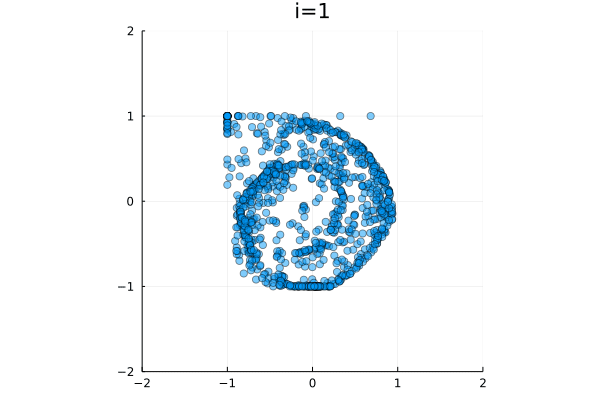

In [ ]:
gif(anim_estimates, joinpath(directory, "estimates.gif"), fps=8)